In [237]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow 
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense , Flatten , BatchNormalization , Dropout , Conv2D , MaxPooling2D , Input , Rescaling , GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
from keras.initializers import HeNormal  , GlorotUniform 
# from keras.applications import ConvNeXtTiny
# from keras.applications.convnext import preprocess_input , decode_predictions
from keras.preprocessing import image_dataset_from_directory
from keras.optimizers import Adam , AdamW
from keras.preprocessing import image
from keras.regularizers import l1_l2 
from keras.applications import EfficientNetB3
from keras.applications.efficientnet import preprocess_input , decode_predictions

In [238]:
train_data = image_dataset_from_directory(
    '/kaggle/input/car-damage-severity-dataset/data3a/training',
    image_size = (224 , 224),
    label_mode = "categorical",
    batch_size = 32
)
test_data = image_dataset_from_directory(
    '/kaggle/input/car-damage-severity-dataset/data3a/validation',
    image_size = (224 , 224),
    label_mode = "categorical",
    batch_size = 32
)

Found 1383 files belonging to 3 classes.
Found 248 files belonging to 3 classes.


In [239]:
for images , labels in train_data.take(1):
    print(images.shape)
    print(labels.shape)

(32, 224, 224, 3)
(32, 3)


In [240]:
class_name = train_data.class_names
class_name

['01-minor', '02-moderate', '03-severe']

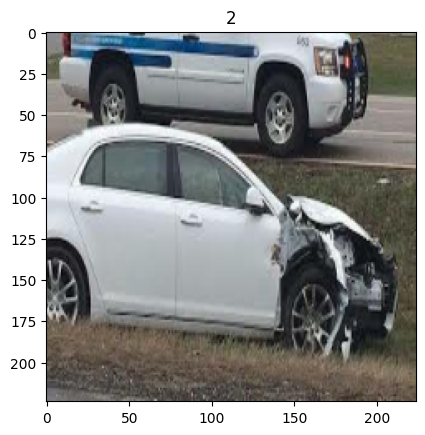

In [241]:
for images, labels in train_data.take(1):
    img = images[0].numpy().astype("uint8")
    label = labels[0].numpy().argmax()
    plt.imshow(img)
    plt.title(label)

In [242]:
def preprocess(image , label):
    image = preprocess_input(image)
    return image , label

data_augmentation = tensorflow.keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.15),
    keras.layers.RandomZoom(0.2),
    keras.layers.RandomContrast(0.2),
    keras.layers.RandomBrightness(0.1),
])

def augment(img, label):
    img = data_augmentation(img, training=True)
    return img, label
    
# train_data = train_data.map(augment, tensorflow.data.AUTOTUNE)

train_data = train_data.map(preprocess)
test_data = test_data.map(preprocess)

In [243]:
train_data = train_data.cache().prefetch(tensorflow.data.AUTOTUNE)
test_data = test_data.cache().prefetch(tensorflow.data.AUTOTUNE)

In [244]:
effinet = EfficientNetB3(weights = 'imagenet' , include_top = False , input_shape = (224 , 224 , 3))

In [245]:
effinet.trainable = False

In [246]:
flag = False
for layer in effinet.layers:
    if layer.name =='block6a_expand_conv':
        flag = True
    if flag == True:
        layer.trainable = True

In [247]:
model = Sequential()

model.add(effinet)
model.add(GlobalAveragePooling2D())
model.add(Dense(128 , activation = 'relu' , kernel_regularizer = l1_l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64 , activation = 'relu' , kernel_regularizer = l1_l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(3 , activation = 'softmax'))

In [248]:
model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,989,490 (41.92 MB)

 Trainable params: 8,711,649 (33.23 MB)

 Non-trainable params: 2,277,841 (8.69 MB)

In [249]:
model.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_16     │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 128)            │       196,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,989,490 (41.92 MB)

 Trainable params: 8,711,649 (33.23 MB)

 Non-trainable params: 2,277,841 (8.69 MB)

In [250]:
model.compile(loss = 'categorical_crossentropy' , optimizer = Adam(learning_rate = 0.001) , metrics = ['accuracy'])

In [251]:
callback = EarlyStopping(
    monitor = 'val_accuracy',
    patience = 15 ,
    min_delta = 0.001,
    restore_best_weights = True ,
    mode = 'auto',
    verbose = 1
)

In [252]:
history = model.fit(train_data , epochs=100 , validation_data = test_data , callbacks = callback)

Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.4834 - loss: 7.8154 - val_accuracy: 0.6774 - val_loss: 6.9686
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.7503 - loss: 6.5593 - val_accuracy: 0.5000 - val_loss: 6.6916
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9001 - loss: 5.4648 - val_accuracy: 0.6331 - val_loss: 5.3862
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9494 - loss: 4.5039 - val_accuracy: 0.6492 - val_loss: 4.5496
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 0.9590 - loss: 3.6257 - val_accuracy: 0.6855 - val_loss: 3.7031
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 0.9764 - loss: 2.7848 - val_accuracy: 0.6250 - val_loss: 3.2408
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 0.9703 - loss: 2.1379 - val_accuracy: 0.6815 - val_loss: 2.4351
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 0.9574 - loss: 1.7370 - val_accur

In [253]:
loss , accuracy = model.evaluate(test_data)
print(f"Model Accuracy :{accuracy*100:.2f}")

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.7594 - loss: 1.9024
Model Accuracy :76.21


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
[[0.01346862 0.22160146 0.76492995]]


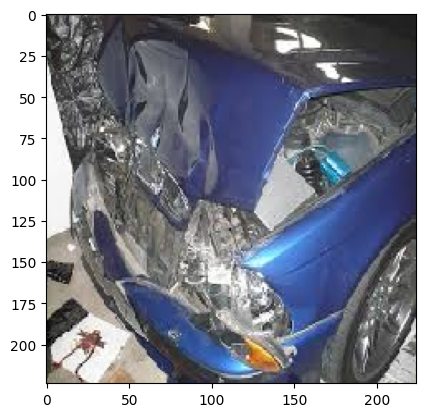

In [254]:
image_path = '/kaggle/input/car-damage-severity-dataset/data3a/validation/03-severe/0009.JPEG'
img = image.load_img(image_path , target_size = (224 , 224))
plt.imshow(img)
img = image.img_to_array(img)
img = preprocess_input(img)
img = np.expand_dims(img, axis=0)

prediction = model.predict(img)
print(prediction)

In [255]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input  

minor_folder    = '/kaggle/input/car-damage-severity-dataset/data3a/validation/01-minor'
moderate_folder = '/kaggle/input/car-damage-severity-dataset/data3a/validation/02-moderate'
severe_folder   = '/kaggle/input/car-damage-severity-dataset/data3a/validation/03-severe'

class_names = ['01-minor', '02-moderate', '03-severe']

def predict_severity(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array) 
    
    pred = model.predict(img_array, verbose=0)[0]
    predicted_class_idx = np.argmax(pred)
    confidence = pred[predicted_class_idx]
    
    return class_names[predicted_class_idx], confidence

def get_images(folder):
    return [f for f in os.listdir(folder) if f.lower().endswith(('.jpeg', '.jpg', '.png', '.JPG' , '.JPEG'))]

minor_images    = get_images(minor_folder)
moderate_images = get_images(moderate_folder)
severe_images   = get_images(severe_folder)

correct_minor = 0
correct_moderate = 0
correct_severe = 0

total_minor = len(minor_images)
total_moderate = len(moderate_images)
total_severe = len(severe_images)

print("TESTING ON VALIDATION FOLDERS (3-class severity)\n")
print(f"Found: {total_minor} minor | {total_moderate} moderate | {total_severe} severe\n")

print("Predicting 01-minor images (should say '01-minor')...")
for img_name in minor_images:
    path = os.path.join(minor_folder, img_name)
    pred_class, conf = predict_severity(path)
    if pred_class == '01-minor':
        correct_minor += 1
print(f"Minor correct: {correct_minor}/{total_minor} → {correct_minor/total_minor:.1%}")

print("\nPredicting 02-moderate images (should say '02-moderate')...")
for img_name in moderate_images:
    path = os.path.join(moderate_folder, img_name)
    pred_class, conf = predict_severity(path)
    if pred_class == '02-moderate':
        correct_moderate += 1
print(f"Moderate correct: {correct_moderate}/{total_moderate} → {correct_moderate/total_moderate:.1%}")

print("\nPredicting 03-severe images (should say '03-severe')...")
for img_name in severe_images:
    path = os.path.join(severe_folder, img_name)
    pred_class, conf = predict_severity(path)
    if pred_class == '03-severe':
        correct_severe += 1
print(f"Severe correct: {correct_severe}/{total_severe} → {correct_severe/total_severe:.1%}")

total_correct = correct_minor + correct_moderate + correct_severe
total_images = total_minor + total_moderate + total_severe

print("\n" + "="*70)
print("                 FINAL VALIDATION ACCURACY (data3a)")
print("="*70)
print(f"01-minor    → {correct_minor}/{total_minor}    ({correct_minor/total_minor:.1%})")
print(f"02-moderate → {correct_moderate}/{total_moderate}    ({correct_moderate/total_moderate:.1%})")
print(f"03-severe   → {correct_severe}/{total_severe}    ({correct_severe/total_severe:.1%})")
print("-"*70)
print(f"TOTAL ACCURACY: {total_correct}/{total_images} → {total_correct/total_images:.1%}")
print("="*70)

TESTING ON VALIDATION FOLDERS (3-class severity)

Found: 82 minor | 75 moderate | 91 severe

Predicting 01-minor images (should say '01-minor')...
Minor correct: 71/82 → 86.6%

Predicting 02-moderate images (should say '02-moderate')...
Moderate correct: 29/75 → 38.7%

Predicting 03-severe images (should say '03-severe')...
Severe correct: 84/91 → 92.3%

                 FINAL VALIDATION ACCURACY (data3a)
01-minor    → 71/82    (86.6%)
02-moderate → 29/75    (38.7%)
03-severe   → 84/91    (92.3%)
----------------------------------------------------------------------
TOTAL ACCURACY: 184/248 → 74.2%


In [257]:
model.save('how_much_damage_model.keras')